In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [2]:
import os
current_dir = os.getcwd()
# Construct the dataset path relative to the current working directory
data_path = os.path.join(current_dir, "..", "dataset", "feeds.csv")
df=pd.read_csv(data_path)

In [3]:
df.head()

,created_at,entry_id,field1,field2,field3,latitude,longitude,elevation,status
0,2024-04-24T12:27:34+00:00,1,6,3,3,NaN,NaN,NaN,NaN
1,2024-04-24T12:27:50+00:00,2,5,3,4,NaN,NaN,NaN,NaN
2,2024-04-24T12:28:05+00:00,3,7,4,4,NaN,NaN,NaN,NaN
3,2024-04-24T12:28:21+00:00,4,8,5,3,NaN,NaN,NaN,NaN
4,2024-04-24T12:28:37+00:00,5,5,4,3,NaN,NaN,NaN,NaN


In [4]:
df=df.drop(['latitude','longitude','elevation','status','entry_id'],axis=1)

In [5]:
df.head()

,created_at,field1,field2,field3
0,2024-04-24T12:27:34+00:00,6,3,3
1,2024-04-24T12:27:50+00:00,5,3,4
2,2024-04-24T12:28:05+00:00,7,4,4
3,2024-04-24T12:28:21+00:00,8,5,3
4,2024-04-24T12:28:37+00:00,5,4,3


In [6]:
df.isna().sum() ## there are no null value

created_at    0
field1        0
field2        0
field3        0
dtype: int64

In [7]:
# Convert the 'created_at' column to seconds since the epoch
df['created_at_seconds'] = df['created_at'].apply(
    lambda x: int(datetime.fromisoformat(x.replace('Z', '+00:00')).timestamp())
)
base_time=df['created_at_seconds'].iloc[0]
df["relative_time"] = df["created_at_seconds"] - base_time
df.drop(['created_at','created_at_seconds'],axis=1,inplace=True)


In [8]:
df

,field1,field2,field3,relative_time
0,6,3,3,0
1,5,3,4,16
2,7,4,4,31
3,8,5,3,47
4,5,4,3,63
...,...,...,...,...
49570,40,0,10,778781
49571,40,0,11,778797
49572,39,0,11,778812
49573,40,0,11,778828


In [9]:
df_field1=pd.DataFrame(columns=[["field","time"]])
df_field1[["field","time"]]=df[["field1","relative_time"]]

df_field2=pd.DataFrame(columns=[["field","time"]])
df_field2[["field","time"]]=df[["field2","relative_time"]]

df_field3=pd.DataFrame(columns=[["field","time"]])
df_field3[["field","time"]]=df[["field3","relative_time"]]


# Field1

In [10]:
# test train split
df=df_field1.copy()
X=df.iloc[:,1:2].values
y=df.iloc[:,0:1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [11]:
# # StandardScalar() is the class used for feature scaling from sklearn library.
X

array([[     0],
       [    16],
       [    31],
       ...,
       [778812],
       [778828],
       [778844]], dtype=int64)

In [12]:
# parforomance_path=os.path.join(os.getcwd,"..", "output", "performance","performance_matrix.csv")
performance_path = os.path.join(os.getcwd(), "..", "output", "performance", "performance_matrix.csv")
performance_matrix=pd.read_csv(performance_path)
for index, row in performance_matrix.iterrows():
    if row["Model"]=="field1 decision_tree":
        R2=row["DataSet R2"]
        RMSE=row["DataSet RMSE"]

In [13]:
y

array([[ 6],
       [ 5],
       [ 7],
       ...,
       [39],
       [40],
       [39]], dtype=int64)

## Support Vector Machine

In [16]:
class model:
  def __init__(self):
    self.sc_X = StandardScaler()
    self.sc_y = StandardScaler()

  def train(self,X_train,y_train):
    X = self.sc_X.fit_transform(X_train)
    y = self.sc_y.fit_transform(y_train)
    self.svm_rbf=SVR(kernel='rbf',C=2000,gamma=1)
    self.svm_rbf.fit(X,y.ravel())

  def predict(self,X_test):
    X_test=self.sc_X.transform(X_test)
    y_pred=self.svm_rbf.predict(X_test)
    y_pred = y_pred.reshape(-1, 1)
    self.y_pred=self.sc_y.inverse_transform(y_pred)
    return self.y_pred

  def evaluate(self,y_test):
    metrics = {
    "Mean Absolute Error (MAE)": mean_absolute_error(y_test, self.y_pred),
    "Mean Squared Error (MSE)": mean_squared_error(y_test, self.y_pred),
    "Root Mean Squared Error (RMSE)": np.sqrt(mean_squared_error(y_test, self.y_pred)),
    "R² Score": r2_score(y_test, self.y_pred)
    }
    return pd.DataFrame(metrics.items(), columns=["Metric", "Value"])


In [ ]:
# traing
model1=model()
model1.train(X_train,y_train)

# test predict
y1_test_pred=model1.predict(X_test)
y1_test_performance=model1.evaluate(y_test)

# data predict
y1_pred=model1.predict(X)
y1_performance=model1.evaluate(y)


# ploting
plt.scatter(X, y, color='red', label='Observed Data')
plt.scatter(X, y1_pred, color='blue', label='RBF Kernel')

# performance printing
performance_matrix = model1.evaluate(y_test)
print(performance_matrix)

## Decition Tree

In [89]:
#  decition tree model
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

class tree_model:
    def __init__(self):
        """
        Initializes the model with StandardScaler for feature scaling.
        """
        self.sc_X = StandardScaler()
        self.sc_y = StandardScaler()

    def train(self, X_train, y_train):
        """
        Trains the Decision Tree Regressor on the scaled data.
        """
        # Scale the features and target
        X = self.sc_X.fit_transform(X_train)
        y = self.sc_y.fit_transform(y_train)

        # Initialize and train the Decision Tree Regressor
        self.tree_regressor = DecisionTreeRegressor(max_depth=15, random_state=42,splitter="random")
        self.tree_regressor.fit(X, y)

    def predict(self, X_test):
        """
        Predicts the target for given test features after scaling.
        """
        # Scale the test features
        X_test = self.sc_X.transform(X_test)

        # Predict and inverse scale the target
        y_pred = self.tree_regressor.predict(X_test)
        y_pred = y_pred.reshape(-1, 1)
        self.y_pred = self.sc_y.inverse_transform(y_pred)
        return self.y_pred

    def evaluate(self, y_test):
      """
      Evaluates the model's performance on test data.
      """
      metrics = {
          "Mean Absolute Error (MAE)": mean_absolute_error(y_test, self.y_pred),
          "Mean Squared Error (MSE)": mean_squared_error(y_test, self.y_pred),
          "Root Mean Squared Error (RMSE)": np.sqrt(mean_squared_error(y_test, self.y_pred)),
          "R² Score": r2_score(y_test, self.y_pred)
      }
      self.performance_matrix=pd.DataFrame(metrics.items(), columns=["Metric", "Value"])
      return self.performance_matrix

    def plot_performance_matrix(self,performance_matrix):
        fig, ax = plt.subplots()
        ax.axis('tight')
        ax.axis('off')
        table = ax.table(cellText=performance_matrix.values, colLabels=performance_matrix.columns, loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.auto_set_column_width(col=list(range(len(performance_matrix.columns))))
        plt.show()

Test Performance


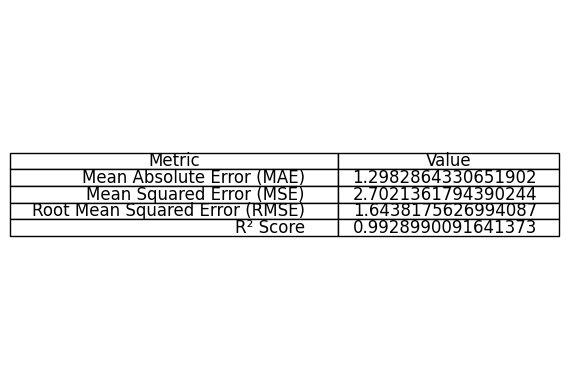

Train Performance


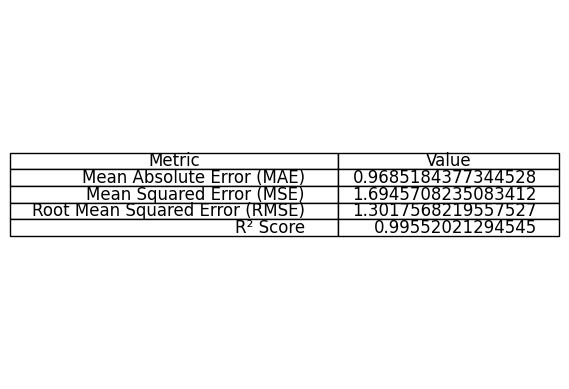

model Performance


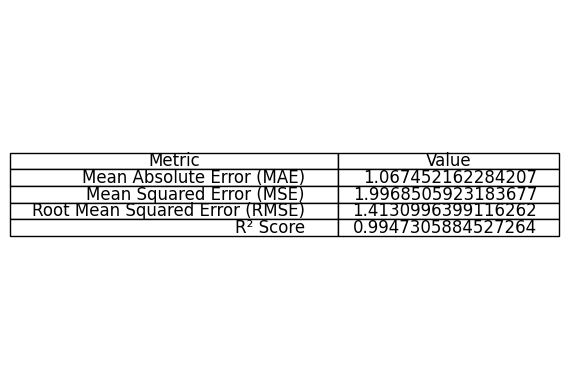

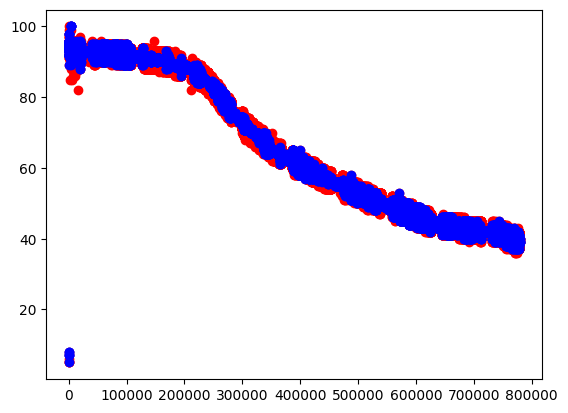

In [90]:
# traing
model1=tree_model()
model1.train(X_train,y_train)

# test predict
y1_test_pred=model1.predict(X_test)
print("Test Performance")
model1.plot_performance_matrix(model1.evaluate(y_test))

# train predict
y1_train_pred=model1.predict(X_train)
print("Train Performance")
model1.plot_performance_matrix(model1.evaluate(y_train))

# data predict
y1_pred=model1.predict(X)
print("model Performance")
model1.plot_performance_matrix(model1.evaluate(y))


# ploting
plt.scatter(X, y, color='red', label='Observed Data')
plt.scatter(X, y1_pred, color='blue', label='RBF Kernel')


## Random Rorest

In [71]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class random_forest_model:
    def __init__(self):
        """
        Initializes the model with StandardScaler for feature scaling.
        """
        self.sc_X = StandardScaler()
        self.sc_y = StandardScaler()

    def train(self, X_train, y_train):
        """
        Trains the Random Forest Regressor on the scaled data.
        """
        # Scale the features and target
        X = self.sc_X.fit_transform(X_train)
        y = self.sc_y.fit_transform(y_train)

        # Initialize and train the Random Forest Regressor
        self.rf_regressor = RandomForestRegressor(
            n_estimators=100,  # Number of trees
            max_depth=30,      # Maximum depth of each tree
            random_state=42,   # Ensures reproducibility
            n_jobs=-1,          # Utilize all processors for training
            min_samples_split=2,
            min_samples_leaf=1,
            max_features=1,
            bootstrap=True
        )
        self.rf_regressor.fit(X, y.ravel())

    def predict(self, X_test):
        """
        Predicts the target for given test features after scaling.
        """
        # Scale the test features
        X_test = self.sc_X.transform(X_test)

        # Predict and inverse scale the target
        y_pred = self.rf_regressor.predict(X_test)
        y_pred = y_pred.reshape(-1, 1)
        self.y_pred = self.sc_y.inverse_transform(y_pred)
        return self.y_pred

    def evaluate(self, y_test):
        """
        Evaluates the model's performance on test data.
        """
        metrics = {
            "Mean Absolute Error (MAE)": mean_absolute_error(y_test, self.y_pred),
            "Mean Squared Error (MSE)": mean_squared_error(y_test, self.y_pred),
            "Root Mean Squared Error (RMSE)": np.sqrt(mean_squared_error(y_test, self.y_pred)),
            "R² Score": r2_score(y_test, self.y_pred)
        }
        self.performance_matrix=pd.DataFrame(metrics.items(), columns=["Metric", "Value"])
        return self.performance_matrix

    def plot_performance_matrix(self,performance_matrix):
        fig, ax = plt.subplots()
        ax.axis('tight')
        ax.axis('off')
        table = ax.table(cellText=performance_matrix.values, colLabels=performance_matrix.columns, loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.auto_set_column_width(col=list(range(len(performance_matrix.columns))))
        plt.show()



Test Performance


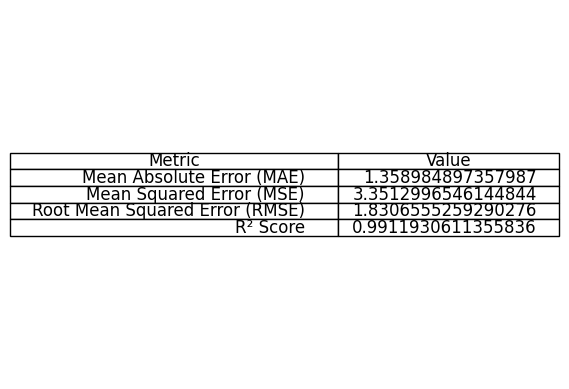

Train Performance


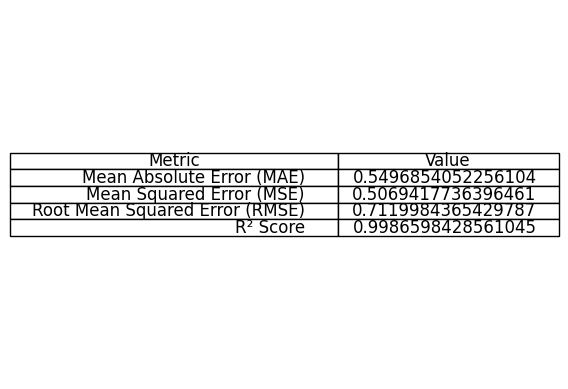

model Performance


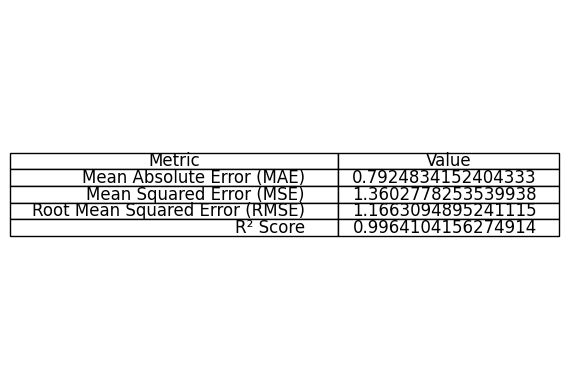

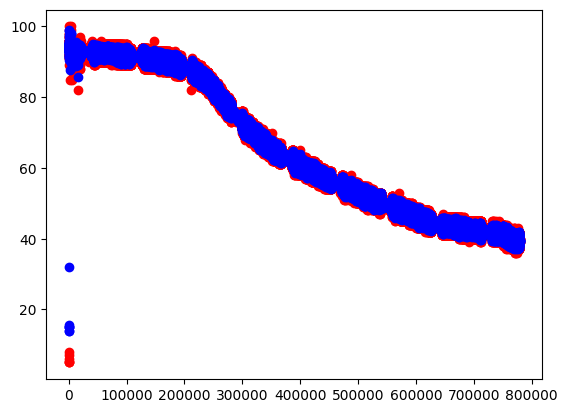

In [72]:
# traing
model1=random_forest_model()
model1.train(X_train,y_train)

# test predict
y1_test_pred=model1.predict(X_test)
print("Test Performance")
model1.plot_performance_matrix(model1.evaluate(y_test))

# train predict
y1_train_pred=model1.predict(X_train)
print("Train Performance")
model1.plot_performance_matrix(model1.evaluate(y_train))

# data predict
y1_pred=model1.predict(X)
print("model Performance")
model1.plot_performance_matrix(model1.evaluate(y))


# ploting
plt.scatter(X, y, color='red', label='Observed Data')
plt.scatter(X, y1_pred, color='blue', label='RBF Kernel')


## Radge Regration

In [91]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class ridge_lasso_model:
    def __init__(self, model_type='ridge', alpha=1.0):
        """
        Initializes the model with StandardScaler for feature scaling and either Ridge or Lasso model.
        :param model_type: 'ridge' for Ridge regression, 'lasso' for Lasso regression
        :param alpha: Regularization strength; larger values mean more regularization
        """
        self.sc_X = StandardScaler()
        self.sc_y = StandardScaler()

        # Initialize the model (Ridge or Lasso)
        if model_type == 'ridge':
            self.model = Ridge(alpha=alpha, random_state=42)
        elif model_type == 'lasso':
            self.model = Lasso(alpha=alpha, random_state=42)
        else:
            raise ValueError("model_type must be 'ridge' or 'lasso'")

    def train(self, X_train, y_train):
        """
        Trains the Ridge or Lasso model on the scaled data.
        """
        # Scale the features and target
        X = self.sc_X.fit_transform(X_train)
        y = self.sc_y.fit_transform(y_train)

        # Train the Ridge or Lasso model
        self.model.fit(X, y.ravel())

    def predict(self, X_test):
        """
        Predicts the target for given test features after scaling.
        """
        # Scale the test features
        X_test = self.sc_X.transform(X_test)

        # Predict and inverse scale the target
        y_pred = self.model.predict(X_test)
        y_pred = y_pred.reshape(-1, 1)
        self.y_pred = self.sc_y.inverse_transform(y_pred)
        return self.y_pred

    def evaluate(self, y_test):
        """
        Evaluates the model's performance on test data.
        """
        metrics = {
            "Mean Absolute Error (MAE)": mean_absolute_error(y_test, self.y_pred),
            "Mean Squared Error (MSE)": mean_squared_error(y_test, self.y_pred),
            "Root Mean Squared Error (RMSE)": np.sqrt(mean_squared_error(y_test, self.y_pred)),
            "R² Score": r2_score(y_test, self.y_pred)
        }
        self.performance_matrix = pd.DataFrame(metrics.items(), columns=["Metric", "Value"])
        return self.performance_matrix

    def plot_performance_matrix(self, performance_matrix):
        fig, ax = plt.subplots()
        ax.axis('tight')
        ax.axis('off')
        table = ax.table(cellText=performance_matrix.values, colLabels=performance_matrix.columns, loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.auto_set_column_width(col=list(range(len(performance_matrix.columns))))
        plt.show()


Test Performance


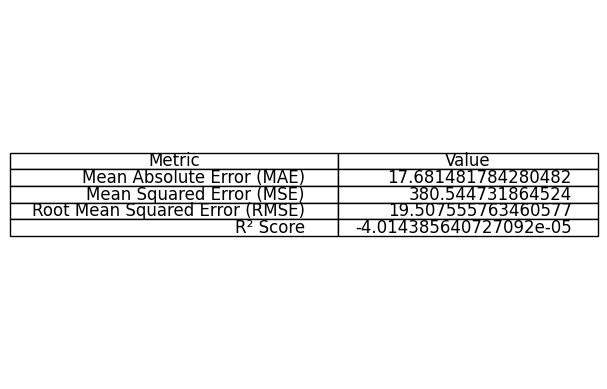

Train Performance


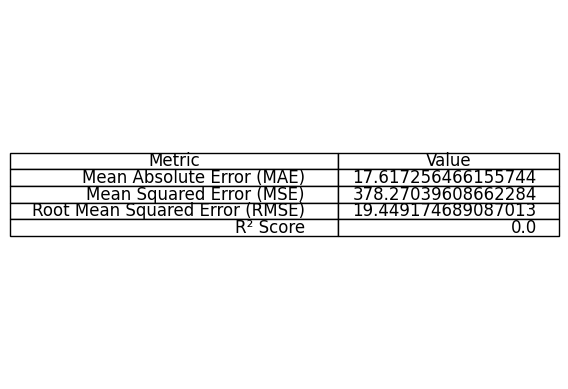

model Performance


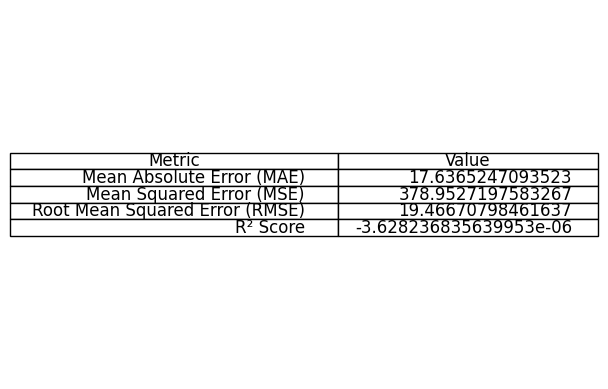

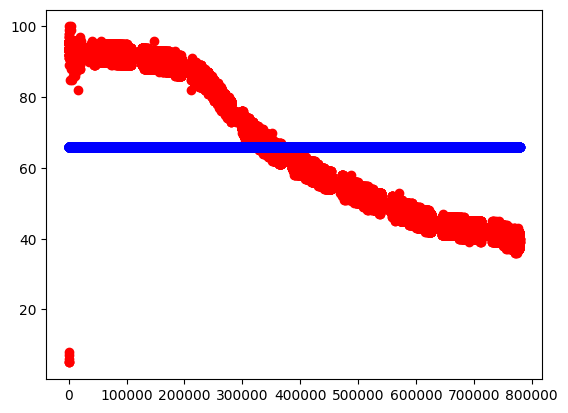

In [95]:
# traing
model1=ridge_lasso_model(model_type='lasso')
model1.train(X_train,y_train)

# test predict
y1_test_pred=model1.predict(X_test)
print("Test Performance")
model1.plot_performance_matrix(model1.evaluate(y_test))

# train predict
y1_train_pred=model1.predict(X_train)
print("Train Performance")
model1.plot_performance_matrix(model1.evaluate(y_train))

# data predict
y1_pred=model1.predict(X)
print("model Performance")
model1.plot_performance_matrix(model1.evaluate(y))


# ploting
plt.scatter(X, y, color='red', label='Observed Data')
plt.scatter(X, y1_pred, color='blue', label='RBF Kernel')


## All Regression

In [14]:
import os

def save_img(plt_obj,name):
    """
    Function to save a given plot object to the specified path.
    :param plt_obj: Matplotlib plot object.
    :param save_path: Path to save the plot.
    """
    
    save_path = f'field1/image/{name}'
    # Ensure the directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)


    plt_obj.savefig(save_path)
    print(f"Plot saved at {save_path}")

# save farformance matrix as csv
def save_performance_matrix_as_csv(performance_matrix, name):
    save_path = f'field1/image/{name}'
    # Ensure the directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    performance_matrix.to_csv(save_path, index=False)


Plot saved at field1/image/Field1_Observed.png


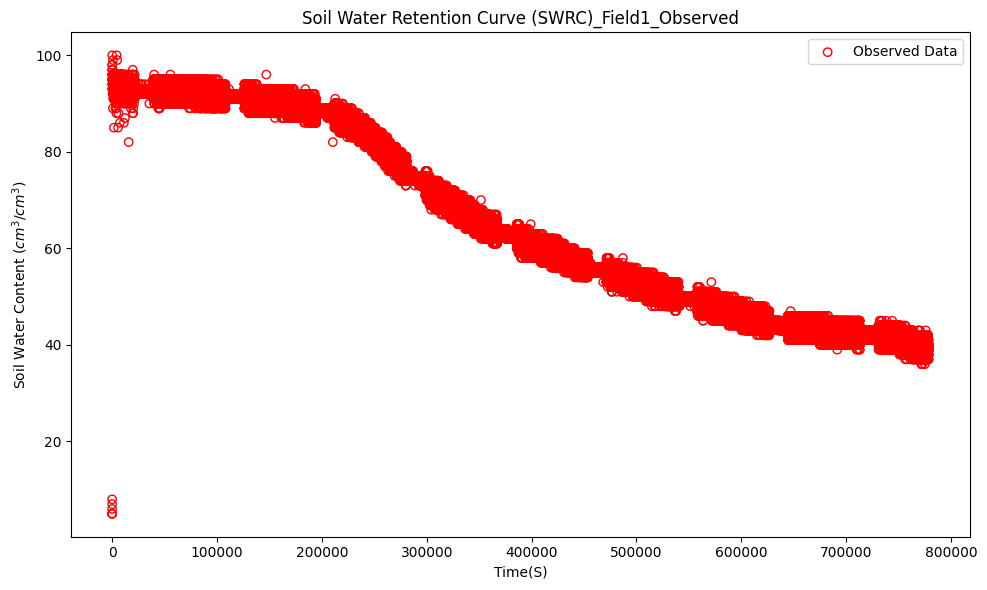

In [15]:
import os
import matplotlib.pyplot as plt

# Plot the figure
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='red', label='Observed Data', facecolors='none', edgecolors='red')

plt.xlabel('Time(S)')
plt.ylabel('Soil Water Content ($cm^3$/$cm^3$)')
plt.legend()  # To show the label
plt.title('Soil Water Retention Curve (SWRC)_Field1_Observed')
plt.tight_layout()

# Save the image to the specified path
save_img(plt_obj=plt,name='Field1_Observed.png')

# Show the plot
plt.show()


In [ ]:
import openpyxl
import pandas as pd

def update_test_performance(model_name, file_path, input_df):
    """
    Update test performance metrics for a model in the Excel sheet based on input DataFrame.

    :param file_path: Path to the Excel file
    :param input_df: DataFrame with two columns: 'Metric' and 'Value' to be updated for the model
    """
    save_path = f'field1/parformance/{file_path}'
        # Ensure the directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    try:
        # Load the existing workbook
        wb = openpyxl.load_workbook(save_path)
        sheet = wb.active
    except FileNotFoundError:
        # If the file does not exist, create a new workbook and sheet
        wb = openpyxl.Workbook()
        sheet = wb.active
        # Set headers if it's a new sheet
        headers = ["Model","Test R2", "Test RMSE", "Train R2", "Train RMSE", "DataSet R2", "DataSet RMSE"]
        sheet.append(headers)

    # Find the row where the model name is located
    model_row = None
    for row in sheet.iter_rows(min_row=2, max_col=1):  # Only check the 'Model' column (first column)
        if row[0].value == model_name:
            model_row = row[0].row
            break
    # Loop through each row in the DataFrame to update the metrics

    if model_row:
        for _, row in input_df.iterrows():
            metric = row['Metric']
            value = row['Value']
            # Loop through the header row to find the correct column for the metric
            for index, header in enumerate(sheet[1]):  # Assuming headers are in row 1
                if header.value == metric:
                    sheet.cell(row=model_row, column=index + 1, value=value)
                    break
            # Save the workbook
            wb.save(save_path)
    else:
        max_row=sheet.max_row+1
        sheet.cell(row=max_row, column=1, value=model_name)
        for metric, value in input_df.values:
            for index, header in enumerate(sheet[1]):  # Assuming headers are in row 1
                if header.value == metric:
                    sheet.cell(row=max_row, column=index+1, value=value)
                    break
        wb.save(save_path)


In [32]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

class MultiRegressor:
    def __init__(self, model_type='decision_tree', alpha=1.0, degree=2):
        """
        Initializes the model with StandardScaler for feature scaling and selected regression model.
        :param model_type: String representing the type of model to use ('decision_tree', 'random_forest',
                            'svm', 'ridge', 'lasso', 'linear', 'polynomial')
        :param alpha: Regularization strength for Ridge and Lasso
        :param degree: Degree of polynomial features for Polynomial Regression
        """
        self.sc_X = StandardScaler()
        self.sc_y = StandardScaler()
        self.model_type = model_type
        self.degree = degree

        if model_type == 'decision_tree':
            self.model =  DecisionTreeRegressor(
                max_depth=15,
                random_state=42,
                splitter="random")


        elif model_type == 'random_forest':
            self.model =  RandomForestRegressor(
            n_estimators=100,  # Number of trees
            max_depth=30,      # Maximum depth of each tree
            random_state=42,   # Ensures reproducibility
            n_jobs=-1,          # Utilize all processors for training
            min_samples_split=2,
            min_samples_leaf=1,
            max_features=1,
            bootstrap=True
        )

        elif model_type == 'svm':
            self.model = self.svm_rbf=SVR(
                kernel='rbf',
                C=2000,
                gamma=1
            )

        elif model_type == 'ridge':
            self.model = Ridge(alpha=alpha, random_state=42)
        elif model_type == 'lasso':
            self.model = Lasso(alpha=alpha, random_state=42)
        elif model_type == 'linear':
            self.model = LinearRegression()
        elif model_type == 'polynomial':
            self.poly = PolynomialFeatures(degree=self.degree)
            self.model = LinearRegression()
        else:
            raise ValueError("Invalid model_type. Choose from ['decision_tree', 'random_forest', 'svm', 'ridge', 'lasso', 'linear', 'polynomial']")

    def train(self, X_train, y_train):
        """
        Trains the selected regression model on the scaled data.
        """
        X = self.sc_X.fit_transform(X_train)
        y = self.sc_y.fit_transform(y_train)

        if self.model_type == 'polynomial':
            X_poly = self.poly.fit_transform(X)
            self.model.fit(X_poly, y)
        else:
            self.model.fit(X, y.ravel())

    def predict(self, X_test):
        """
        Predicts the target for given test features after scaling.
        """
        X_test = self.sc_X.transform(X_test)

        if self.model_type == 'polynomial':
            X_test_poly = self.poly.transform(X_test)
            y_pred = self.model.predict(X_test_poly)
        else:
            y_pred = self.model.predict(X_test)

        y_pred = y_pred.reshape(-1, 1)
        self.y_pred = self.sc_y.inverse_transform(y_pred)
        return self.y_pred

    def evaluate(self, y_test,mod):
        """
        Evaluates the model's performance on test data.
        """
        metrics = {
            f"{mod} RMSE": np.sqrt(mean_squared_error(y_test, self.y_pred)),
            f"{mod} R2": r2_score(y_test, self.y_pred)
        }
        self.performance_matrix = pd.DataFrame(metrics.items(), columns=["Metric", "Value"])
        return self.performance_matrix

    def R2_mse(self, y_test):
        R2 = r2_score(y_test, self.y_pred)
        MSE = np.sqrt(mean_squared_error(y_test, self.y_pred))
        return R2, MSE

    def plot_performance_matrix(self, performance_matrix):
        fig, ax = plt.subplots()
        ax.axis('tight')
        ax.axis('off')
        table = ax.table(cellText=performance_matrix.values, colLabels=performance_matrix.columns, loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.auto_set_column_width(col=list(range(len(performance_matrix.columns))))
        plt.show()
    
    # save image
    def save_img(self, plt_obj, name):
        """
        Function to save a given plot object to the specified path.
        :param plt_obj: Matplotlib plot object.
        :param save_path: Path to save the plot.
        """
        
        save_path = f'field1/image/{name}.png'
        # Ensure the directory exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt_obj.savefig(save_path)
        print(f"Plot saved at {save_path}")

    # save farformance matrix as csv
    def save_performance_matrix_as_csv(self,performance_matrix, name):
        save_path = f'field1/parformance/{name}.csv'
        # Ensure the directory exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        performance_matrix.to_csv(save_path, index=False)


    


In [24]:
field="field1"
model_type="decision_tree"

current_dir = os.getcwd()
data_path = os.path.join(current_dir, "..", "dataset",f"{field}", f"df_{field}.csv")
# read file
print(data_path)
df=pd.read_csv(data_path)
df_predict=df.copy()
# Splte X and y, X= Time  
X=df.iloc[:,1:2].values #  X= Time 
y=df.iloc[:,0:1].values #  y= field
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

d:\projects\internship\code\notebook code\..\dataset\field1\df_field1.csv


Plot saved at field1/image/Field1_Decition_Tree.png


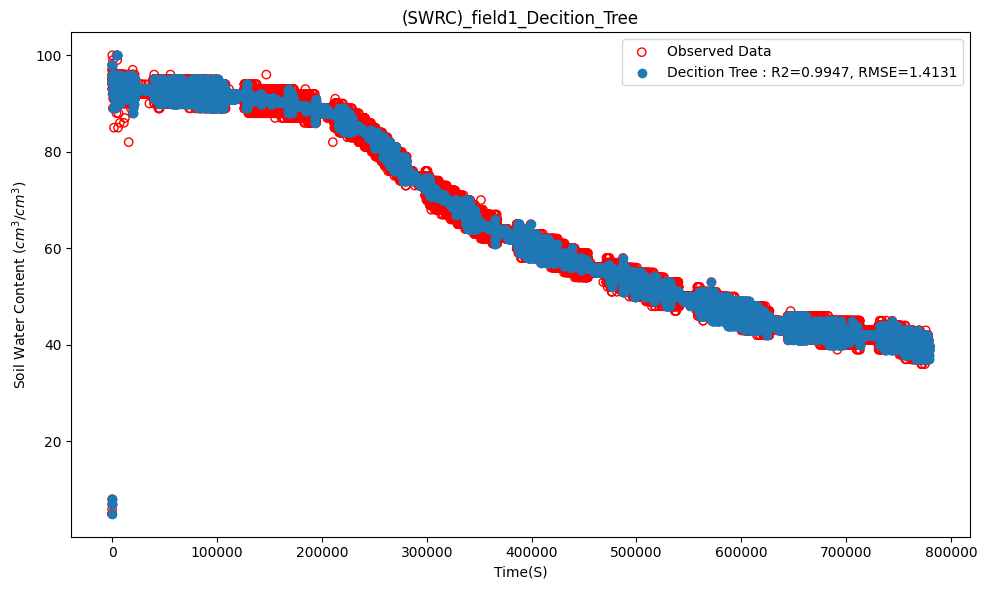

In [ ]:
# decition Tree
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
field="Field1"
# traing
model_decition_tree=MultiRegressor(model_type='decision_tree')
model_decition_tree.train(X_train,y_train)

# test predict
y1_test_pred_decition_tree=model_decition_tree.predict(X_test)
# print("Test Performance")
# model_decition_tree.plot_performance_matrix(model_decition_tree.evaluate(mod="Test",y_test=y_test))
# model_decition_tree.save_performance_matrix_as_csv(performance_matrix=model_decition_tree.evaluate(y_test),name='decision_tree')
update_test_performance(model_name=f"{field}Decition Tree",file_path="performance_matrix.xlsx",input_df=model_decition_tree.evaluate(y_test=y_test,mod="Test")
)
# train predict
y1_train_pred_decition_tree=model_decition_tree.predict(X_train)
# print("Train Performance")
# model_decition_tree.plot_performance_matrix(model_decition_tree.evaluate(y_test=y_train,mod="Train"))
update_test_performance(model_name=f"{field}Decition Tree",file_path="performance_matrix.xlsx",input_df=model_decition_tree.evaluate(y_test=y_train,mod="Train")
)
# data predict
y1_pred_decition_tree=model_decition_tree.predict(X)
# print("model Performance")
# model_decition_tree.plot_performance_matrix(model_decition_tree.evaluate(y_test=y,mod="DataSet"))
update_test_performance(model_name=f"{field}Decition Tree",file_path="performance_matrix.xlsx",input_df=model_decition_tree.evaluate(y_test=y,mod="DataSet")
)

R2_decition_tree,RMSE_decition_tree=model_decition_tree.R2_mse(y)


# ploting
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='red', label='Observed Data',facecolors='none', edgecolors='red')
plt.scatter(X, y1_pred_decition_tree,label=f'Decition Tree : R2={R2_decition_tree:.4f}, RMSE={RMSE_decition_tree:.4f}')

plt.xlabel('Time(S)')
plt.ylabel('Soil Water Content ($cm^3$/$cm^3$)')
plt.legend() # to show label
plt.title('(SWRC)_field1_Decition_Tree')
plt.tight_layout()

# Save and show the plot
model_decition_tree.save_img(plt_obj=plt,name='Field1_Decition_Tree')
plt.show()

Plot saved at field1/image/Field1_Random_Forest.png


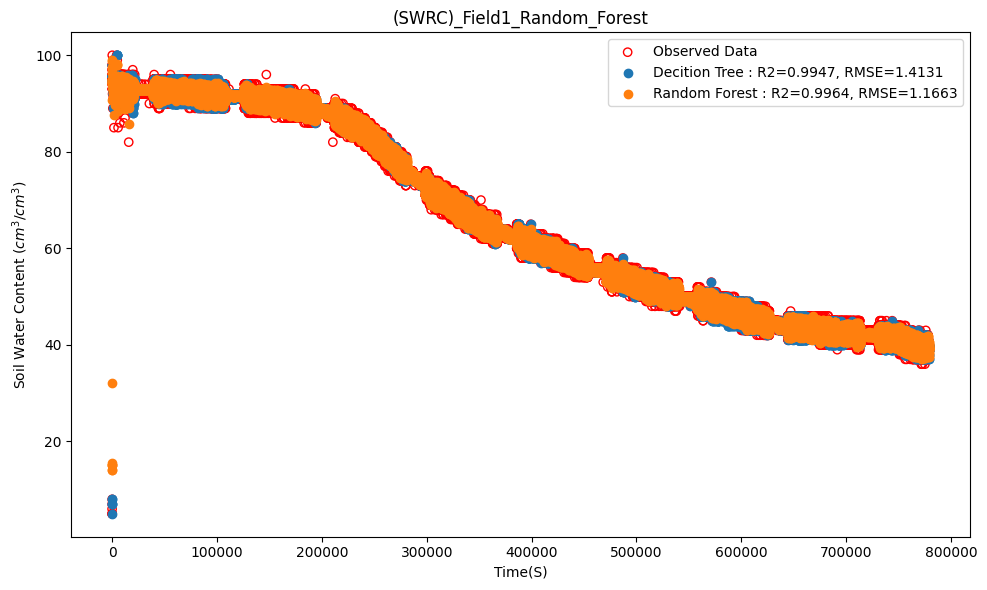

In [42]:
# Random Forest
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# traing
field="Field1"
model_random_forest=MultiRegressor(model_type='random_forest')
model_random_forest.train(X_train,y_train)

# test predict
y1_test_pred_random_forest=model_random_forest.predict(X_test)
# print("Test Performance")

# model_random_forest.plot_performance_matrix(model_random_forest.evaluate(y_test))
# model_random_forest.plot_performance_matrix(model_random_forest.evaluate(mod="Test",y_test=y_test))
update_test_performance(model_name=f"{field} Random Forest",file_path="performance_matrix.xlsx",input_df=model_random_forest.evaluate(y_test=y_test,mod="Test")
)


# train predict
y1_train_pred_random_forest=model_random_forest.predict(X_train)
# print("Train Performance")
# model_random_forest.plot_performance_matrix(model_random_forest.evaluate(y_train))
# model_random_forest.plot_performance_matrix(model_random_forest.evaluate(y_test=y_train,mod="Train"))
update_test_performance(model_name=f"{field} Random Forest",file_path="performance_matrix.xlsx",input_df=model_random_forest.evaluate(y_test=y_train,mod="Train")
)


# data predict
y1_pred_random_forest=model_random_forest.predict(X)
# print("model Performance")
# model_random_forest.plot_performance_matrix(model_random_forest.evaluate(y))
# model_random_forest.plot_performance_matrix(model_random_forest.evaluate(y_test=y,mod="DataSet"))
update_test_performance(model_name=f"{field} Random Forest",file_path="performance_matrix.xlsx",input_df=model_random_forest.evaluate(y_test=y,mod="DataSet")
)
R2_random_forest,RMSE_random_forest=model_random_forest.R2_mse(y)


# ploting
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='red', label='Observed Data',facecolors='none', edgecolors='red')
plt.scatter(X, y1_pred_decition_tree,  label=f'Decition Tree : R2={R2_decition_tree:.4f}, RMSE={RMSE_decition_tree:.4f}')
plt.scatter(X, y1_pred_random_forest,  label=f'Random Forest : R2={R2_random_forest:.4f}, RMSE={RMSE_random_forest:.4f}')

plt.xlabel('Time(S)')
plt.ylabel('Soil Water Content ($cm^3$/$cm^3$)')
plt.legend() # to show label
plt.title('(SWRC)_Field1_Random_Forest')
plt.tight_layout()

# Save and show the plot
# plt.savefig('Field1_Random_Forest.png')
model_decition_tree.save_img(plt_obj=plt,name='Field1_Random_Forest')
plt.show()

Test Performance
Train Performance
model Performance
Plot saved at field1/image/Field1_Ridge_rigrassion.png


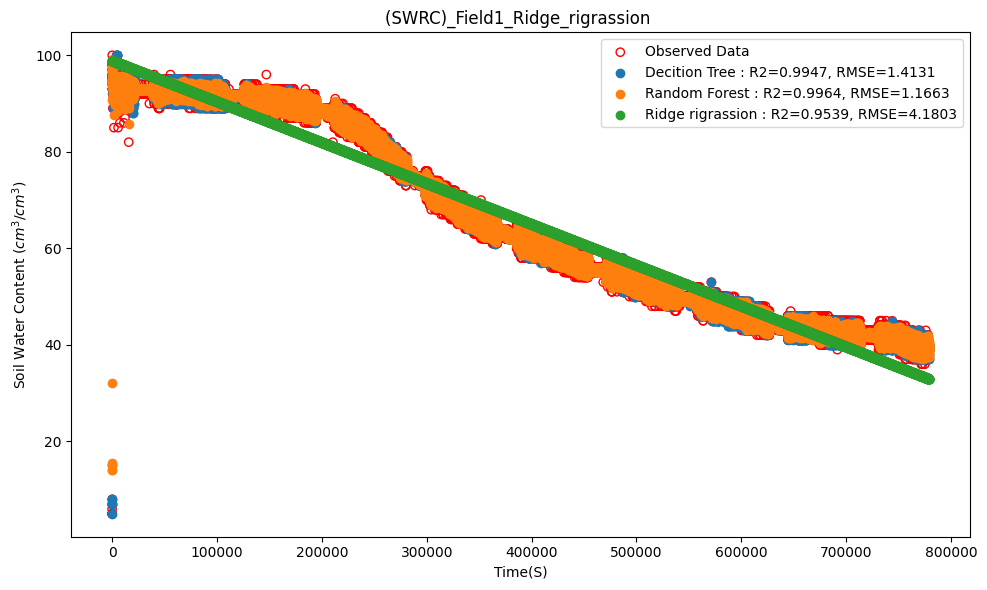

In [43]:
# Ridge rigrassion
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# traing
model_ridge=MultiRegressor(model_type='ridge')
model_ridge.train(X_train,y_train)

# test predict
y1_test_pred_ridge=model_ridge.predict(X_test)
print("Test Performance")
model_ridge.evaluate(y_test=y_test,mod="Test")
update_test_performance(model_name=f"{field} Ridge rigrassion",file_path="performance_matrix.xlsx",input_df=model_ridge.evaluate(y_test=y_test,mod="Test")
)
# train predict
y1_train_pred_ridge=model_ridge.predict(X_train)
print("Train Performance")
model_ridge.evaluate(y_test=y_train,mod="Train")
update_test_performance(model_name=f"{field} Ridge rigrassion",file_path="performance_matrix.xlsx",input_df=model_ridge.evaluate(y_test=y_train,mod="Train")
)
# data predict
y1_pred_ridge=model_ridge.predict(X)
print("model Performance")
model_ridge.evaluate(y_test=y,mod="DataSet")
update_test_performance(model_name=f"{field} Ridge rigrassion",file_path="performance_matrix.xlsx",input_df=model_ridge.evaluate(y_test=y,mod="DataSet")
)
R2_ridge,RMSE_ridge=model_ridge.R2_mse(y)


# ploting
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='red', label='Observed Data',facecolors='none', edgecolors='red')
plt.scatter(X, y1_pred_decition_tree, label=f'Decition Tree : R2={R2_decition_tree:.4f}, RMSE={RMSE_decition_tree:.4f}')
plt.scatter(X, y1_pred_random_forest, label=f'Random Forest : R2={R2_random_forest:.4f}, RMSE={RMSE_random_forest:.4f}')
plt.scatter(X, y1_pred_ridge,  label=f'Ridge rigrassion : R2={R2_ridge:.4f}, RMSE={RMSE_ridge:.4f}')


plt.xlabel('Time(S)')
plt.ylabel('Soil Water Content ($cm^3$/$cm^3$)')
plt.legend() # to show label
plt.title('(SWRC)_Field1_Ridge_rigrassion ')
plt.tight_layout()

# Save and show the plot
model_ridge.save_img(plt,'Field1_Ridge_rigrassion')
plt.show()

Test Performance


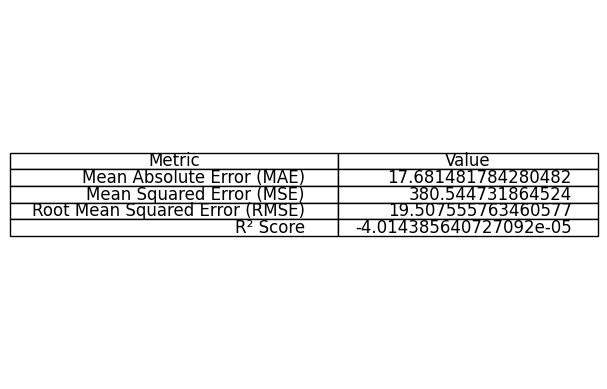

Train Performance


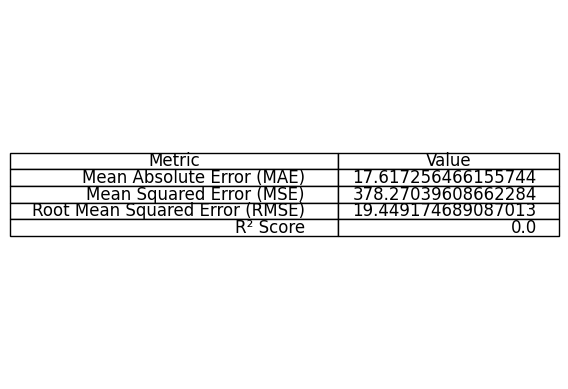

model Performance


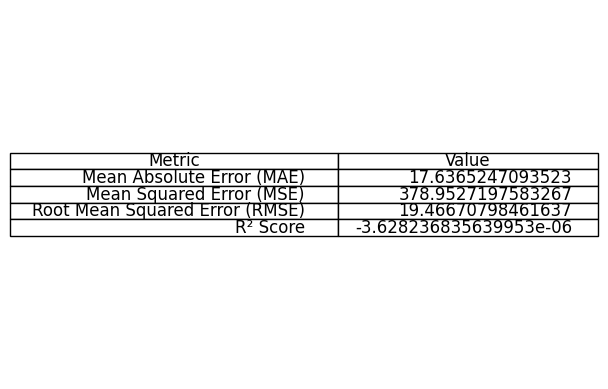

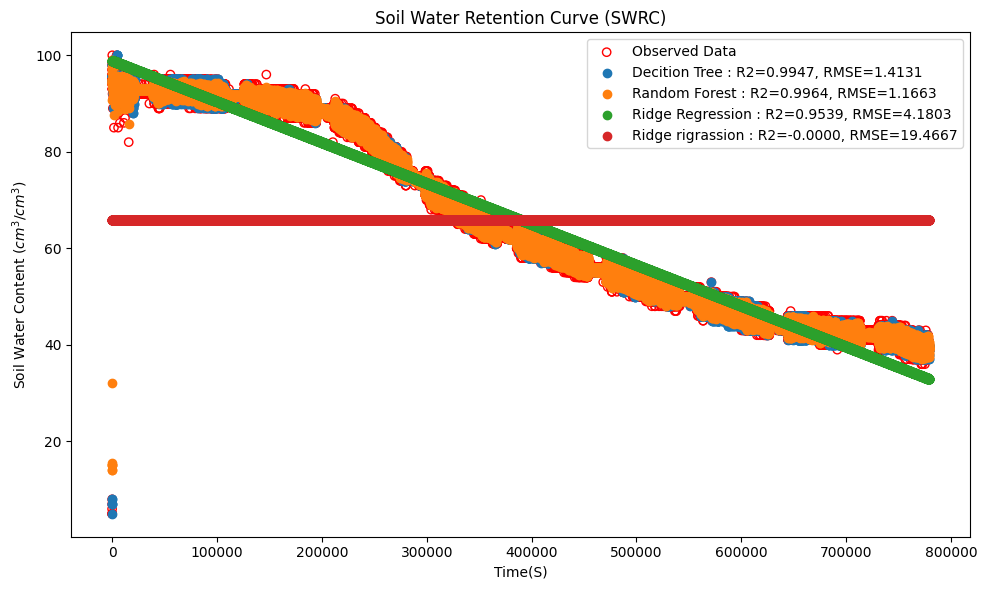

In [ ]:
# Lasso rigrassion
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
# ['decision_tree', 'random_forest', 'svm', 'ridge', 'lasso', 'linear', 'polynomial']7# traing
model_lasso=MultiRegressor(model_type='lasso')
model_lasso.train(X_train,y_train)

# test predict
y1_test_pred_lasso=model_lasso.predict(X_test)
print("Test Performance")
update_test_performance(model_name=f"{field} Lasso rigrassion",file_path="performance_matrix.xlsx",input_df=model_lasso.evaluate(y_test=y_test,mod="Test")
)
# train predict
y1_train_pred_lasso=model_lasso.predict(X_train)
print("Train Performance")
update_test_performance(model_name=f"{field} Lasso rigrassion",file_path="performance_matrix.xlsx",input_df=model_lasso.evaluate(y_test=y_train,mod="Test")
)
# data predict
y1_pred_lasso=model_lasso.predict(X)
print("model Performance")
model_lasso.plot_performance_matrix(model_lasso.evaluate(y))
R2_lasso,RMSE_lasso=model_lasso.R2_mse(y)


# ploting
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='red', label='Observed Data',facecolors='none', edgecolors='red')
plt.scatter(X, y1_pred_decition_tree,  label=f'Decition Tree : R2={R2_decition_tree:.4f}, RMSE={RMSE_decition_tree:.4f}')
plt.scatter(X, y1_pred_random_forest,  label=f'Random Forest : R2={R2_random_forest:.4f}, RMSE={RMSE_random_forest:.4f}')
plt.scatter(X, y1_pred_ridge,  label=f'Ridge Regression : R2={R2_ridge:.4f}, RMSE={RMSE_ridge:.4f}')
plt.scatter(X, y1_pred_lasso,  label=f'Ridge rigrassion : R2={R2_lasso:.4f}, RMSE={RMSE_lasso:.4f}')



plt.xlabel('Time(S)')
plt.ylabel('Soil Water Content ($cm^3$/$cm^3$)')
plt.legend() # to show label
plt.title('Soil Water Retention Curve (SWRC)')
plt.tight_layout()

# Save and show the plot
plt.savefig('Field1_Lasso_rigrassion.png')
plt.show()

Test Performance


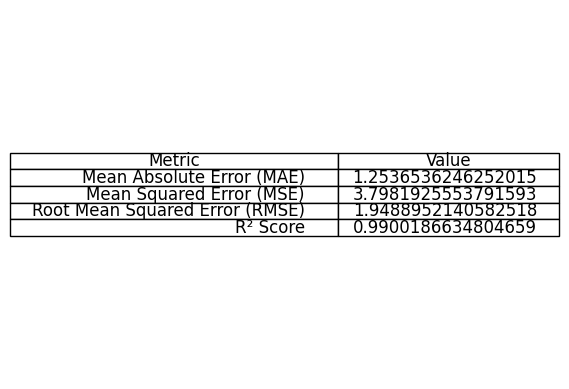

Train Performance


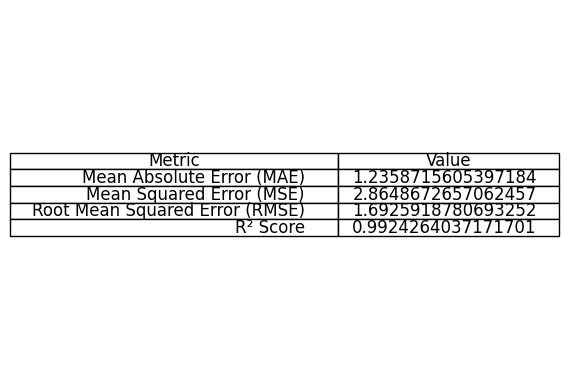

model Performance


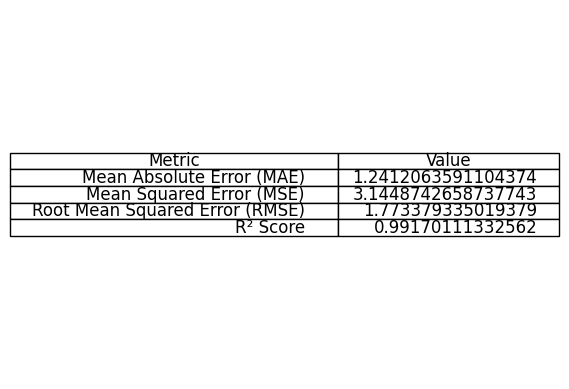

<Figure size 1000x600 with 0 Axes>

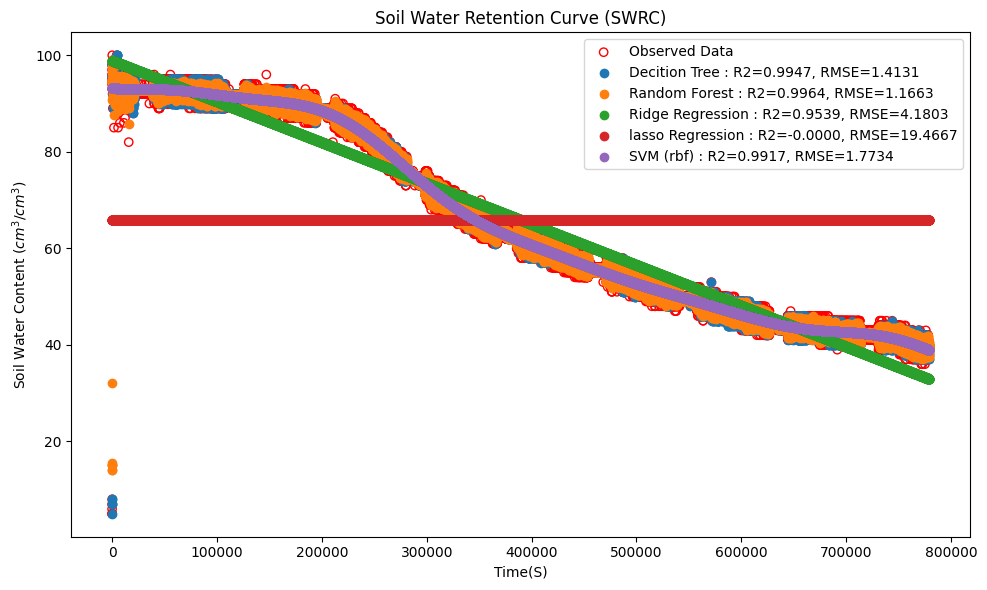

In [20]:
# Support Vector Machine
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
# ['decision_tree', 'random_forest', 'svm', 'ridge', 'lasso', 'linear', 'polynomial']7# traing
model_svm=MultiRegressor(model_type='svm')
model_svm.train(X_train,y_train)

# test predict
y1_test_pred_svm=model_svm.predict(X_test)
print("Test Performance")
model_svm.plot_performance_matrix(model_svm.evaluate(y_test))

# train predict
y1_train_pred_svm=model_svm.predict(X_train)
print("Train Performance")
model_svm.plot_performance_matrix(model_svm.evaluate(y_train))

# data predict
y1_pred_svm=model_svm.predict(X)
print("model Performance")
model_svm.plot_performance_matrix(model_svm.evaluate(y))
R2_svm,RMSE_svm=model_svm.R2_mse(y)


# ploting
plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='red', label='Observed Data',facecolors='none', edgecolors='red')
plt.scatter(X, y1_pred_decition_tree,  label=f'Decition Tree : R2={R2_decition_tree:.4f}, RMSE={RMSE_decition_tree:.4f}')
plt.scatter(X, y1_pred_random_forest,  label=f'Random Forest : R2={R2_random_forest:.4f}, RMSE={RMSE_random_forest:.4f}')
plt.scatter(X, y1_pred_ridge,  label=f'Ridge Regression : R2={R2_ridge:.4f}, RMSE={RMSE_ridge:.4f}')
plt.scatter(X, y1_pred_lasso,  label=f'lasso Regression : R2={R2_lasso:.4f}, RMSE={RMSE_lasso:.4f}')
plt.scatter(X, y1_pred_svm, label=f'SVM (rbf) : R2={R2_svm:.4f}, RMSE={RMSE_svm:.4f}')


plt.xlabel('Time(S)')
plt.ylabel('Soil Water Content ($cm^3$/$cm^3$)')
plt.legend() # to show label
plt.title('Soil Water Retention Curve (SWRC)')
plt.tight_layout()

# Save and show the plot
plt.savefig('Field1_SVM(rbf).png')
plt.show()